In [231]:
import pandas as pd
import numpy as np
import re
import json
import numpy as np
import timeit 
from datetime import datetime

In [232]:
import tensorflow as tf
from tensorflow import keras

In [233]:
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme

import plotly.figure_factory as ff

import plotly.graph_objects as go
import plotly.express as px

In [234]:
from sklearn.model_selection import train_test_split

In [235]:
#Selecting a central city point to center all graphs around - Swietokrzyska Subway 
center_coors=52.235176, 21.008393

In [236]:
df=pd.read_excel("RE_models_input.xlsx")

In [237]:
df.columns

Index(['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'building_floors_num', 'rooms_num', 'City', 'subdistrict', 'market',
       'Building_material', 'Building_ownership', 'Building_type',
       'Construction_status', 'floor_no', 'Heating', 'Windows_type',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm

In [238]:
df['rooms_num']=np.where(df['rooms_num']=="more",10,df['rooms_num'])

In [239]:
df.drop(columns=['floor_no',"City","district_old",'price_decrease_from_20k','price_decrease_per_10min'],inplace=True)

In [240]:
df.columns

Index(['Id', 'Area', 'Price', 'latitude', 'longitude', 'build_year',
       'building_floors_num', 'rooms_num', 'subdistrict', 'market',
       'Building_material', 'Building_ownership', 'Building_type',
       'Construction_status', 'Heating', 'Windows_type',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_

In [241]:
df["distance_driving"]=(df.distance_driving_8AM+df.distance_return_driving_5PM)/2
df["distance_transit"]=(df.distance_transit_8AM+df.distance_return_transit_5PM)/2
df["time_driving"]=(df.time_driving_8AM+df.time_return_driving_5PM)/2
df["time_transit"]=(df.time_return_transit_5PM+df.time_transit_8AM)/2

In [242]:
df.drop(columns=['distance_transit_8AM', 'time_transit_8AM', 'distance_driving_8AM',
       'time_driving_8AM', 'distance_return_transit_5PM',
       'time_return_transit_5PM', 'distance_return_driving_5PM',
       'time_return_driving_5PM'],inplace=True)

# Data exploration

## Category composition

In [243]:
unique_features=["district","market","Building_material","Building_ownership","Building_type","Construction_status","Heating",
"Windows_type"]

In [244]:
for feature in unique_features:
    feature_list=["Id"]
    feature_list.append(feature)

    df_temp=df[feature_list].groupby(feature, as_index=False).count()
    df_temp.rename(columns={"Id":"share"},inplace=True)
    df_temp.sort_values(by="share",inplace=True, ascending=False)
    df_temp["share"]=df_temp["share"]/df.shape[0]
    df_temp["share"]=np.around(df_temp["share"],3)*100
    df_temp["colour"]=np.where(df_temp[feature]=="not_specified","missing_data","valid_data")
    
    fig = px.bar(df_temp, x=feature, y='share', color="colour",
                 color_discrete_sequence=["blue", "red"],
                 category_orders={"colour": ["valid_data", "missing_data"]},)
    print("\n Feature summary for {} - Share of category within whole sample".format(feature))
    fig.show()
    print("----------------------------------------------------------------------------------------------------------------------------\n\n\n")

    


 Feature summary for district - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for market - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Building_material - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Building_ownership - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Building_type - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Construction_status - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Heating - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------




 Feature summary for Windows_type - Share of category within whole sample


----------------------------------------------------------------------------------------------------------------------------





## Average unit price by feature 

In [245]:
for feature in unique_features:
    feature_list=["unit_price"]
    feature_list.append(feature)

    df_temp=df[feature_list]
    
    print("\n Unit price distribution in split by {}".format(feature))
    
    fig = fig = px.box(df_temp, y="unit_price", x=feature, points="suspectedoutliers");
    fig.update_yaxes(range=[5000, 25000])


    print("----------------------------------------------------------------------------------------------------------------------------\n\n\n")

    


 Unit price distribution in split by district


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by market


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Building_material


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Building_ownership


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Building_type


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Construction_status


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Heating


----------------------------------------------------------------------------------------------------------------------------




 Unit price distribution in split by Windows_type


----------------------------------------------------------------------------------------------------------------------------





# Transforming data for ML models

In [246]:
from sklearn.preprocessing import OneHotEncoder

In [247]:
df_cat=df[unique_features]

In [248]:
enc=OneHotEncoder()
enc.fit(df_cat)

one_hot_val=enc.fit_transform(df_cat).toarray().astype(int)
one_hot_columns=enc.get_feature_names(unique_features)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [249]:
df_one_hot=pd.DataFrame(one_hot_val, columns=one_hot_columns)

In [250]:
df_one_hot.columns

Index(['district_Bemowo', 'district_Bialoleka', 'district_Bielany',
       'district_Downtown', 'district_Mokotow', 'district_Ochota',
       'district_Praga', 'district_Southern Praga', 'district_Subburbs',
       'district_Targowek', 'district_Ursynow', 'district_Wawer',
       'district_Wilanow', 'district_Wlochy', 'district_Wola',
       'district_Zoliborz', 'market_primary', 'market_secondary',
       'Building_material_breezeblock', 'Building_material_brick',
       'Building_material_cellular_concrete', 'Building_material_concrete',
       'Building_material_concrete_plate', 'Building_material_hydroton',
       'Building_material_not_specified', 'Building_material_other',
       'Building_material_reinforced_concrete', 'Building_material_silikat',
       'Building_material_wood', 'Building_ownership_co_operative_ownership',
       'Building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe',
       'Building_ownership_full_ownership', 'Building_ownership_not_spec

In [251]:
not_specified_idx=[]
for i in range(0,df_one_hot.columns.shape[0]):
    if "not_specified" in df_one_hot.columns[i]:
        not_specified_idx.append(i)
not_specified_idx=np.asarray(not_specified_idx)

Let's drop all "not_specified" columns and secondary market in Mokotow district (it will be used as baseline in models)

In [252]:
drop_collinear_cols=list(df_one_hot.columns[not_specified_idx])
drop_collinear_cols.append('district_Mokotow')
drop_collinear_cols.append('market_secondary')

In [253]:
def list_diff(list1, list2):
    out = []
    for ele in list1:
        if not ele in list2:
            out.append(ele)
    return out

In [254]:
df_one_hot.columns

Index(['district_Bemowo', 'district_Bialoleka', 'district_Bielany',
       'district_Downtown', 'district_Mokotow', 'district_Ochota',
       'district_Praga', 'district_Southern Praga', 'district_Subburbs',
       'district_Targowek', 'district_Ursynow', 'district_Wawer',
       'district_Wilanow', 'district_Wlochy', 'district_Wola',
       'district_Zoliborz', 'market_primary', 'market_secondary',
       'Building_material_breezeblock', 'Building_material_brick',
       'Building_material_cellular_concrete', 'Building_material_concrete',
       'Building_material_concrete_plate', 'Building_material_hydroton',
       'Building_material_not_specified', 'Building_material_other',
       'Building_material_reinforced_concrete', 'Building_material_silikat',
       'Building_material_wood', 'Building_ownership_co_operative_ownership',
       'Building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe',
       'Building_ownership_full_ownership', 'Building_ownership_not_spec

In [255]:
df_cat_columns=list_diff(df_one_hot.columns,drop_collinear_cols)

In [256]:
df_cat=df_one_hot[df_cat_columns]

In [257]:
columns_base=list_diff(df.columns, unique_features)

In [258]:
drop_columns_base=[
    'Price','latitude','longitude','lon_mod','lat_mod','grid_price','sample_size','City','subdistrict'
                  ]

In [259]:
columns_base=list_diff(columns_base, drop_columns_base)

In [260]:
df_base=df[columns_base]

In [261]:
df_base.columns

Index(['Id', 'Area', 'build_year', 'building_floors_num', 'rooms_num',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_types_anti_burglary_door', 'Security_types_closed_area',
       'Security_types_entryphone', 'Security_types_monitoring',
       'Security_types_roller_shutters', 'floor_num', 'unit_price',


## Combining data for modeling

In [262]:
ml_data=pd.concat([df_base,df_cat],axis=1)

In [263]:
ml_data.shape

(11788, 89)

In [264]:
ml_data.head()

Id   Area  build_year  building_floors_num rooms_num  \
0  60534950  80.10        2021                    8         4   
1  60534789  52.27        2021                    8         2   
2  60534636  64.63        2021                    8         3   
3  60441425  46.86        2020                   14         3   
4  60225257  57.40        2019                   11         3   

   Equipment_types_dishwasher  Equipment_types_fridge  \
0                           0                       0   
1                           0                       0   
2                           0                       0   
3                           0                       0   
4                           1                       1   

   Equipment_types_furniture  Equipment_types_oven  Equipment_types_stove  \
0                          0                     0                      0   
1                          0                     0                      0   
2                          0                     0                      0   
3                          0                     0                      0   
4                          1                     1                      1   

   ...  Construction_status_to_completion  Construction_status_to_renovation  \
0  ...                                  0                                  0   
1  ...                                  0                                  0   
2  ...                                  0                                  0   
3  ...                                  0                                  0   
4  ...                                  0                                  0   

   Heating_boiler_room  Heating_electrical  Heating_gas  Heating_other  \
0                    0                   0            0              0   
1                    0                   0            0              0   
2                    0                   0            0              0   
3                    0                   0            0              0   
4                    0                   0            0              0   

   Heating_urban  Windows_type_aluminium  Windows_type_plastic  \
0              0                       0                     0   
1              0                       0                     0   
2              0                       0                     0   
3              0                       0                     0   
4              1                       0                     1   

   Windows_type_wooden  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  

[5 rows x 89 columns]

In [265]:
ml_data.columns[:]

Index(['Id', 'Area', 'build_year', 'building_floors_num', 'rooms_num',
       'Equipment_types_dishwasher', 'Equipment_types_fridge',
       'Equipment_types_furniture', 'Equipment_types_oven',
       'Equipment_types_stove', 'Equipment_types_tv',
       'Equipment_types_washing_machine', 'Extras_types_air_conditioning',
       'Extras_types_attic', 'Extras_types_balcony', 'Extras_types_basement',
       'Extras_types_garage', 'Extras_types_garden', 'Extras_types_lift',
       'Extras_types_separate_kitchen', 'Extras_types_terrace',
       'Extras_types_two_storey', 'Extras_types_usable_room',
       'Media_types_cable-television', 'Media_types_electricity',
       'Media_types_internet', 'Media_types_phone', 'Media_types_sewage',
       'Media_types_water', 'Security_types_alarm',
       'Security_types_anti_burglary_door', 'Security_types_closed_area',
       'Security_types_entryphone', 'Security_types_monitoring',
       'Security_types_roller_shutters', 'floor_num', 'unit_price',


# Selecting best features

In [266]:
counts, bins = np.histogram(ml_data.unit_price, bins=range(0, 50000, 1000))
bins = bins[1:]

fig = px.bar(x=bins, y=counts, labels={'x':'Unit price', 'y':'count'})
fig.show()

In [267]:
X=ml_data.copy()
X=X.query("unit_price<=25000 and unit_price>5000")
y=X.unit_price
X.drop(columns=["unit_price","Id"],inplace=True)

In [268]:
from sklearn.feature_selection import SelectKBest, f_regression, chi2

In [269]:
bestfeatures = SelectKBest(score_func=f_regression, k="all")

In [270]:
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [271]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']

In [272]:
featureScores.nlargest(30,'Score')

Specs        Score
35                   distance_driving  6889.140723
36                   distance_transit  6725.884253
38                       time_transit  5360.201112
37                       time_driving  4741.988679
42                  district_Downtown  3516.937318
40                 district_Bialoleka  1766.097573
75             Building_type_tenement   769.001425
54                     market_primary   701.343385
70                Building_type_block   629.435651
46                  district_Subburbs   582.320969
1                          build_year   515.887396
86                Windows_type_wooden   485.833201
69            Building_type_apartment   432.437679
76   Construction_status_ready_to_use   391.845786
77  Construction_status_to_completion   325.990756
2                 building_floors_num   323.696341
34                          floor_num   315.967698
3                           rooms_num   289.864371
11      Extras_types_air_conditioning   282.383245
52                      district_Wola   265.199542
13               Extras_types_balcony   188.918810
83                      Heating_urban   188.315507
6           Equipment_types_furniture   164.443512
16                Extras_types_garden   162.097546
56            Building_material_brick   158.490793
49                     district_Wawer   153.862225
39                    district_Bemowo   138.977967
67  Building_ownership_full_ownership   128.395893
4          Equipment_types_dishwasher   123.863883
25                  Media_types_phone   121.156862

In [273]:
featureScores.query("Score>40").shape

(51, 2)

In [274]:
top_features=featureScores.nlargest(30,'Score').Specs.unique()

In [275]:
featureScores.sort_values(by="Score",inplace=True,ascending=False)

import plotly.express as px
fig = px.bar(featureScores, x='Specs', y='Score')
fig.show()

In [276]:
X=X[top_features]

## Spliting into train and test sets

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [278]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Training initial model

In [279]:
from sklearn.ensemble import RandomForestRegressor

## Hyper parameters selection

In [280]:
param_grid = [
   
    
    { "bootstrap":[False],
     "n_estimators":[300],
     "max_features":[10,15,20,30],"max_depth":[10,15,20,25,30],"min_samples_leaf":[3,6,12],"min_samples_split":[6,12,24],
     "min_impurity_decrease":[0.01,0.03,0.1,0.3]
},
    
]

In [281]:
from sklearn.model_selection import GridSearchCV

In [282]:
forest_cl=RandomForestRegressor(random_state=10, n_jobs=2)

In [283]:
grid_search = GridSearchCV(forest_cl, param_grid, cv=4,
                          scoring="neg_mean_absolute_error",return_train_score=True)

In [284]:
#grid_search.fit(X_train, y_train)
#rf_clf_best_params = grid_search.best_estimator_


In [285]:
#grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
#grid_search.best_params_.keys()

In [288]:
#rf_model=grid_search.best_estimator_

rf_model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.01,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=2, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [289]:
rf_model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.01,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=2, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [290]:
rf_model.score(X_train,y_train)

0.8948822323367764

In [291]:
rf_model.score(X_test,y_test)

0.6942192231860257

In [292]:
importance_df=pd.DataFrame(rf_model.feature_importances_,columns=["coefficients"])
importance_df["features"]=X.columns
importance_df.sort_values(by="coefficients",inplace=True)

In [293]:

trace0=go.Bar(
        x=importance_df.coefficients,
        y=importance_df.features,
        orientation="h",
        
        marker=dict(
        color="blue",

        opacity=0.5
        ),
       
    )








data=[trace0]
figure=go.Figure(
    data=data,
    layout=go.Layout(
        title="RF Classifier - Feature importance",
        xaxis=dict(title="Importance"),
        yaxis=dict(title="Feature")

    
    ))
iplot(figure)

In [294]:
def performance_summary(model, X_train,y_train, X_test, y_test ):
    
    y_hat=model.predict(X_test)
    
    df_summary=pd.DataFrame(y_hat, columns=["y_hat"])
    df_summary["y_true"]=y_test
    df_summary["predicted_rank"]=df_summary.y_hat.rank()
    df_summary["abs_error"]=np.abs(df_summary.y_true-df_summary.y_hat)
    df_summary["error"]=df_summary.y_hat-df_summary.y_true
    df_summary["relative_error"]= df_summary["error"]/df_summary.y_true
    df_summary["relative_abs_error"]= df_summary["abs_error"]/df_summary.y_true
    df_summary.sort_values(by="predicted_rank",inplace=True)
    df_summary.reset_index(drop=True, inplace=True)
    
    print("Share of forecasts within 25% absolute error {:.2f}\n".format(df_summary.query("relative_abs_error<0.25").shape[0]/df_summary.shape[0]))
    
    print("Share of forecasts within 10% absolute error {:.2f}\n".format(df_summary.query("relative_abs_error<0.10").shape[0]/df_summary.shape[0]))
    
    print("Share of forecasts within 5% absolute error {:.2f}\n".format(df_summary.query("relative_abs_error<0.05").shape[0]/df_summary.shape[0]))
    
    return(df_summary)
    

## Error analysis

In [295]:
df_summary=performance_summary(rf_model, X_train,y_train, X_test, y_test)

Share of forecasts within 25% absolute error 0.93

Share of forecasts within 10% absolute error 0.68

Share of forecasts within 5% absolute error 0.45



In [296]:
df_summary.describe()

y_hat        y_true  predicted_rank     abs_error         error  \
count   2330.000000   2330.000000     2330.000000   2330.000000   2330.000000   
mean   11115.221709  11115.604721     1165.500000   1054.023484     -0.383012   
std     2445.812283   2986.134603      672.757324   1270.907009   1651.256188   
min     5948.696700   5357.000000        1.000000      0.785800 -11647.491826   
25%     9409.605871   9007.750000      583.250000    250.442715   -572.386772   
50%    10895.196716  10698.000000     1165.500000    651.088525     61.157643   
75%    12400.003881  12498.250000     1747.750000   1392.450294    716.763620   
max    23270.928575  25000.000000     2330.000000  11647.491826  10065.413455   

       relative_error  relative_abs_error  
count     2330.000000         2330.000000  
mean         0.018684            0.092704  
std          0.142342            0.109603  
min         -0.465900            0.000077  
25%         -0.049092            0.023930  
50%          0.006108            0.057948  
75%          0.070896            0.122748  
max          1.455818            1.455818

In [297]:
df_summary.head()

y_hat  y_true  predicted_rank    abs_error        error  \
0  5948.696700    6055             1.0   106.303300  -106.303300   
1  6298.582540    6745             2.5   446.417460  -446.417460   
2  6298.582540    5829             2.5   469.582540   469.582540   
3  6474.559743    7726             4.0  1251.440257 -1251.440257   
4  6484.770458    6209             5.0   275.770458   275.770458   

   relative_error  relative_abs_error  
0       -0.017556            0.017556  
1       -0.066185            0.066185  
2        0.080560            0.080560  
3       -0.161978            0.161978  
4        0.044415            0.044415

In [298]:


trace0=go.Scatter(
        name="Predicted",
        y=df_summary.y_true,
        x=df_summary.y_true,
        mode='lines',
        marker=dict(
        size=5,
        opacity=0.3
        ),
       
    )




trace1=go.Scatter(
        name="Actual",
        y=df_summary.y_hat,
        x=df_summary.y_true,
        mode='markers',
        marker=dict(
        color="blue",
    
        size=5,
        opacity=0.1
        ),
        text=df_summary.error
       
    )




data=[trace0,trace1]
figure=go.Figure(
    data=data,
    layout=go.Layout(
        title="Predicted vs actual unit price",
        yaxis=dict(title="Predicted price",range=(0,25000)),
        xaxis=dict(title="Actual price")

    
    ))

iplot(figure)

In [299]:
counts, bins = np.histogram(df_summary.relative_error*100,bins=range(-50,50,2))
counts=counts/df_summary.shape[0]*100
bins=bins[1:]

In [300]:

fig = px.bar(x=bins, y=counts, labels={"x":"relative variance [%]", "y":"count"})
fig.show()

In [301]:
df_summary

y_hat  y_true  predicted_rank    abs_error        error  \
0      5948.696700    6055             1.0   106.303300  -106.303300   
1      6298.582540    6745             2.5   446.417460  -446.417460   
2      6298.582540    5829             2.5   469.582540   469.582540   
3      6474.559743    7726             4.0  1251.440257 -1251.440257   
4      6484.770458    6209             5.0   275.770458   275.770458   
...            ...     ...             ...          ...          ...   
2325  20953.030470   21551          2326.0   597.969530  -597.969530   
2326  21186.325029   23043          2327.0  1856.674971 -1856.674971   
2327  21507.769471   19928          2328.0  1579.769471  1579.769471   
2328  23196.404815   24500          2329.0  1303.595185 -1303.595185   
2329  23270.928575   24000          2330.0   729.071425  -729.071425   

      relative_error  relative_abs_error  
0          -0.017556            0.017556  
1          -0.066185            0.066185  
2           0.080560            0.080560  
3          -0.161978            0.161978  
4           0.044415            0.044415  
...              ...                 ...  
2325       -0.027747            0.027747  
2326       -0.080574            0.080574  
2327        0.079274            0.079274  
2328       -0.053208            0.053208  
2329       -0.030378            0.030378  

[2330 rows x 7 columns]

# Neural networks models

## Transforming and scaling data for NN

In [302]:
def DNN_plot_loss(history, starting_epoch):

        trace0=go.Scatter(
                y=history.history['loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="blue",
                size=5,
                opacity=0.5
                ),
                name="Training Loss"
            )


        trace1=go.Scatter(
                y=history.history['val_loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="red",
                size=5,
                opacity=0.5
                ),
                name="Validation Loss"
            )

        data=[trace0, trace1]
        figure=go.Figure(
            data=data,
            layout=go.Layout(
                title="Learning curve",
                yaxis=dict(title="Loss"),
                xaxis=dict(title="Epoch",range=(starting_epoch,history.epoch[-1])),
                legend=dict(
                    x=1,
                    y=1,
                    traceorder="normal",
                    font=dict(
                        family="sans-serif",
                        size=12,
                        color="black"
                    ),
                bgcolor=None


            )))
        iplot(figure)

In [303]:
y_train=np.asarray(y_train).reshape(-1,1)
y_train.shape

(9317, 1)

In [304]:
y_test=np.asarray(y_test).reshape(-1,1)
y_test.shape

(2330, 1)

In [305]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [306]:
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [307]:
X_train.shape

(9317, 30)

In [308]:
X_test.shape

(2330, 30)

## Initial model

In [309]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

DNN=keras.models.Sequential([
    
    keras.layers.Dense(256, input_dim = X_train.shape[1]),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=256),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=124),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=124),
    keras.layers.LeakyReLU(),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=56),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(units=1, activation="linear"),



])

In [310]:
DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7936      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

[0, 199, 0, 0.01]

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Learning Rate')

Text(0.5, 1.0, 'Power Scheduling')

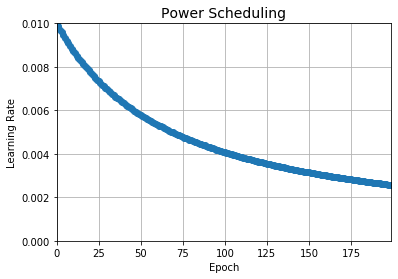

In [311]:
n_epochs=200
learning_rate = 0.01
decay = 5e-5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [312]:
optimizer = keras.optimizers.Adam(lr=0.01, decay=5e-5)



DNN.compile(optimizer=optimizer, 
            loss='mean_absolute_error',
            metrics=['mean_absolute_error'])


history = DNN.fit(X_train, y_train,
                    epochs=400,batch_size=1000,
                    validation_data=(X_test, y_test),
                    verbose=1)

Train on 9317 samples, validate on 2330 samples
Epoch 1/400
9317/9317 [==============================] - 2s 246us/sample - loss: 11111.8178 - mean_absolute_error: 11111.8184 - val_loss: 10987.0373 - val_mean_absolute_error: 10987.0381
Epoch 2/400
9317/9317 [==============================] - 0s 13us/sample - loss: 11083.3979 - mean_absolute_error: 11083.3975 - val_loss: 10554.4681 - val_mean_absolute_error: 10554.4688
Epoch 3/400
9317/9317 [==============================] - 0s 13us/sample - loss: 11004.2138 - mean_absolute_error: 11004.2139 - val_loss: 10079.5323 - val_mean_absolute_error: 10079.5322
Epoch 4/400
9317/9317 [==============================] - 0s 14us/sample - loss: 10833.1365 - mean_absolute_error: 10833.1367 - val_loss: 9881.3889 - val_mean_absolute_error: 9881.3887
Epoch 5/400
9317/9317 [==============================] - 0s 15us/sample - loss: 10509.3211 - mean_absolute_error: 10509.3213 - val_loss: 9610.2410 - val_mean_absolute_error: 9610.2402
Epoch 6/400
9317/9317 [==

9317/9317 [==============================] - 0s 13us/sample - loss: 1293.1451 - mean_absolute_error: 1293.1453 - val_loss: 1578.2668 - val_mean_absolute_error: 1578.2667
Epoch 46/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1294.9744 - mean_absolute_error: 1294.9744 - val_loss: 1435.1066 - val_mean_absolute_error: 1435.1066
Epoch 47/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1284.2497 - mean_absolute_error: 1284.2498 - val_loss: 1422.8398 - val_mean_absolute_error: 1422.8398
Epoch 48/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1271.2604 - mean_absolute_error: 1271.2604 - val_loss: 1440.3037 - val_mean_absolute_error: 1440.3036
Epoch 49/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1263.4014 - mean_absolute_error: 1263.4014 - val_loss: 1359.6669 - val_mean_absolute_error: 1359.6670
Epoch 50/400
9317/9317 [==============================] - 0s 16us/sample - loss: 1270.3378 - mean_

9317/9317 [==============================] - 0s 13us/sample - loss: 1203.3250 - mean_absolute_error: 1203.3251 - val_loss: 1227.0788 - val_mean_absolute_error: 1227.0787
Epoch 90/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1190.5751 - mean_absolute_error: 1190.5752 - val_loss: 1234.9183 - val_mean_absolute_error: 1234.9183
Epoch 91/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1195.1198 - mean_absolute_error: 1195.1198 - val_loss: 1264.1730 - val_mean_absolute_error: 1264.1730
Epoch 92/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1198.7881 - mean_absolute_error: 1198.7880 - val_loss: 1231.7238 - val_mean_absolute_error: 1231.7238
Epoch 93/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1193.4361 - mean_absolute_error: 1193.4360 - val_loss: 1249.6782 - val_mean_absolute_error: 1249.6781
Epoch 94/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1197.9008 - mean_

Epoch 134/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1154.8301 - mean_absolute_error: 1154.8302 - val_loss: 1211.7162 - val_mean_absolute_error: 1211.7163
Epoch 135/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1153.2252 - mean_absolute_error: 1153.2252 - val_loss: 1220.8779 - val_mean_absolute_error: 1220.8779
Epoch 136/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1153.5749 - mean_absolute_error: 1153.5748 - val_loss: 1198.9861 - val_mean_absolute_error: 1198.9862
Epoch 137/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1140.4029 - mean_absolute_error: 1140.4031 - val_loss: 1203.3206 - val_mean_absolute_error: 1203.3204
Epoch 138/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1141.4693 - mean_absolute_error: 1141.4692 - val_loss: 1207.1209 - val_mean_absolute_error: 1207.1210
Epoch 139/400
9317/9317 [==============================] - 0s 17us/sample - loss

9317/9317 [==============================] - 0s 14us/sample - loss: 1114.5286 - mean_absolute_error: 1114.5286 - val_loss: 1205.4374 - val_mean_absolute_error: 1205.4374
Epoch 179/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1108.0214 - mean_absolute_error: 1108.0214 - val_loss: 1199.8695 - val_mean_absolute_error: 1199.8695
Epoch 180/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1105.4357 - mean_absolute_error: 1105.4357 - val_loss: 1190.0204 - val_mean_absolute_error: 1190.0203
Epoch 181/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1113.3600 - mean_absolute_error: 1113.3601 - val_loss: 1196.0348 - val_mean_absolute_error: 1196.0348
Epoch 182/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1108.1754 - mean_absolute_error: 1108.1754 - val_loss: 1199.2164 - val_mean_absolute_error: 1199.2164
Epoch 183/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1107.8207 - 

9317/9317 [==============================] - 0s 13us/sample - loss: 1097.0170 - mean_absolute_error: 1097.0170 - val_loss: 1185.3199 - val_mean_absolute_error: 1185.3199
Epoch 223/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1086.2775 - mean_absolute_error: 1086.2775 - val_loss: 1188.7721 - val_mean_absolute_error: 1188.7721
Epoch 224/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1085.3661 - mean_absolute_error: 1085.3660 - val_loss: 1191.0801 - val_mean_absolute_error: 1191.0801
Epoch 225/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1091.2347 - mean_absolute_error: 1091.2349 - val_loss: 1192.8453 - val_mean_absolute_error: 1192.8453
Epoch 226/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1089.2725 - mean_absolute_error: 1089.2725 - val_loss: 1182.6372 - val_mean_absolute_error: 1182.6372
Epoch 227/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1082.4296 - 

9317/9317 [==============================] - 0s 12us/sample - loss: 1063.3378 - mean_absolute_error: 1063.3378 - val_loss: 1191.1308 - val_mean_absolute_error: 1191.1309
Epoch 267/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1072.9276 - mean_absolute_error: 1072.9276 - val_loss: 1191.2245 - val_mean_absolute_error: 1191.2246
Epoch 268/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1080.4082 - mean_absolute_error: 1080.4083 - val_loss: 1186.3560 - val_mean_absolute_error: 1186.3560
Epoch 269/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1068.9564 - mean_absolute_error: 1068.9564 - val_loss: 1184.2413 - val_mean_absolute_error: 1184.2413
Epoch 270/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1064.8765 - mean_absolute_error: 1064.8767 - val_loss: 1185.6873 - val_mean_absolute_error: 1185.6874
Epoch 271/400
9317/9317 [==============================] - 0s 16us/sample - loss: 1065.9503 - 

9317/9317 [==============================] - 0s 13us/sample - loss: 1054.9739 - mean_absolute_error: 1054.9738 - val_loss: 1184.2291 - val_mean_absolute_error: 1184.2291
Epoch 311/400
9317/9317 [==============================] - 0s 18us/sample - loss: 1054.6644 - mean_absolute_error: 1054.6644 - val_loss: 1174.4157 - val_mean_absolute_error: 1174.4156
Epoch 312/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1060.0706 - mean_absolute_error: 1060.0706 - val_loss: 1187.3401 - val_mean_absolute_error: 1187.3401
Epoch 313/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1046.7676 - mean_absolute_error: 1046.7677 - val_loss: 1192.4037 - val_mean_absolute_error: 1192.4038
Epoch 314/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1059.3920 - mean_absolute_error: 1059.3920 - val_loss: 1183.6163 - val_mean_absolute_error: 1183.6163
Epoch 315/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1053.8521 - 

9317/9317 [==============================] - 0s 14us/sample - loss: 1039.7419 - mean_absolute_error: 1039.7421 - val_loss: 1178.1285 - val_mean_absolute_error: 1178.1285
Epoch 355/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1022.6425 - mean_absolute_error: 1022.6426 - val_loss: 1172.2804 - val_mean_absolute_error: 1172.2804
Epoch 356/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1029.5795 - mean_absolute_error: 1029.5795 - val_loss: 1179.6739 - val_mean_absolute_error: 1179.6741
Epoch 357/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1021.5250 - mean_absolute_error: 1021.5250 - val_loss: 1180.1247 - val_mean_absolute_error: 1180.1246
Epoch 358/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1045.7065 - mean_absolute_error: 1045.7065 - val_loss: 1177.7862 - val_mean_absolute_error: 1177.7860
Epoch 359/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1024.0049 - 

9317/9317 [==============================] - 0s 19us/sample - loss: 1028.5657 - mean_absolute_error: 1028.5658 - val_loss: 1172.8837 - val_mean_absolute_error: 1172.8838
Epoch 399/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1022.2328 - mean_absolute_error: 1022.2328 - val_loss: 1174.3950 - val_mean_absolute_error: 1174.3949
Epoch 400/400
9317/9317 [==============================] - 0s 13us/sample - loss: 1018.5296 - mean_absolute_error: 1018.5297 - val_loss: 1171.0427 - val_mean_absolute_error: 1171.0426


In [324]:
DNN_plot_loss(history,starting_epoch=30)

In [314]:
df_summary_dnn=performance_summary(DNN, X_train,y_train, X_test, y_test)

Share of forecasts within 25% absolute error 0.92

Share of forecasts within 10% absolute error 0.63

Share of forecasts within 5% absolute error 0.38



In [315]:
df_summary_dnn.describe()

y_hat        y_true  predicted_rank     abs_error         error  \
count   2330.000000   2330.000000     2330.000000   2330.000000   2330.000000   
mean   10872.417969  11115.604721     1165.500000   1171.042711   -243.191144   
std     2476.450195   2986.134603      672.757324   1347.283050   1768.596656   
min     5947.364746   5357.000000        1.000000      1.147949 -14632.049805   
25%     9138.827881   9007.750000      583.250000    298.166504   -933.831055   
50%    10638.240234  10698.000000     1165.500000    750.082031   -108.392334   
75%    12064.557129  12498.250000     1747.750000   1559.488281    556.461182   
max    23045.496094  25000.000000     2330.000000  14632.049805  10644.496094   

       relative_error  relative_abs_error  
count     2330.000000         2330.000000  
mean        -0.003645            0.100205  
std          0.143050            0.102134  
min         -0.585282            0.000141  
25%         -0.082592            0.028908  
50%         -0.009527            0.070772  
75%          0.056849            0.136244  
max          1.045781            1.045781

In [316]:
def plot_predictions(df_summary):

    trace0=go.Scatter(
            name="Predicted",
            y=df_summary.y_true,
            x=df_summary.y_true,
            mode='lines',
            marker=dict(
            size=5,
            opacity=0.3
            ),

        )




    trace1=go.Scatter(
            name="Actual",
            y=df_summary.y_hat,
            x=df_summary.y_true,
            mode='markers',
            marker=dict(
            color="blue",

            size=5,
            opacity=0.1
            ),
            text=df_summary_dnn.error

        )




    data=[trace0,trace1]
    figure=go.Figure(
        data=data,
        layout=go.Layout(
            title="Predicted vs actual unit price",
            yaxis=dict(title="Predicted price",range=(0,25000)),
            xaxis=dict(title="Actual price")


        ))

    iplot(figure)

In [317]:
plot_predictions(df_summary_dnn)

## Modified model

In [318]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)

DNN_mod=keras.models.Sequential([
    
    keras.layers.Dense(256, input_dim = X_train.shape[1], activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),

    keras.layers.Dense(units=256,  activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=124, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=124, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(units=56, activation="relu"),
    keras.layers.Dense(units=1, activation="linear"),

])


In [319]:
optimizer = keras.optimizers.Adam(lr=0.01, decay=5e-5)



DNN_mod.compile(optimizer=optimizer, 
            loss='mean_absolute_error',
            metrics=['mean_absolute_error'])


history2 = DNN_mod.fit(X_train, y_train,
                    epochs=400,batch_size=1000,
                    validation_data=(X_test, y_test),
                    verbose=1)

Train on 9317 samples, validate on 2330 samples
Epoch 1/400
9317/9317 [==============================] - 2s 246us/sample - loss: 11111.1542 - mean_absolute_error: 11111.1533 - val_loss: 11050.6571 - val_mean_absolute_error: 11050.6562
Epoch 2/400
9317/9317 [==============================] - 0s 13us/sample - loss: 11072.2674 - mean_absolute_error: 11072.2676 - val_loss: 10939.7263 - val_mean_absolute_error: 10939.7256
Epoch 3/400
9317/9317 [==============================] - 0s 14us/sample - loss: 10971.3220 - mean_absolute_error: 10971.3223 - val_loss: 10726.3412 - val_mean_absolute_error: 10726.3408
Epoch 4/400
9317/9317 [==============================] - 0s 14us/sample - loss: 10759.1896 - mean_absolute_error: 10759.1895 - val_loss: 10307.2788 - val_mean_absolute_error: 10307.2793
Epoch 5/400
9317/9317 [==============================] - 0s 13us/sample - loss: 10364.8714 - mean_absolute_error: 10364.8711 - val_loss: 9869.4743 - val_mean_absolute_error: 9869.4736
Epoch 6/400
9317/9317 [

9317/9317 [==============================] - 0s 11us/sample - loss: 1363.8714 - mean_absolute_error: 1363.8713 - val_loss: 1877.2021 - val_mean_absolute_error: 1877.2021
Epoch 46/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1363.1182 - mean_absolute_error: 1363.1183 - val_loss: 1973.6567 - val_mean_absolute_error: 1973.6566
Epoch 47/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1357.8949 - mean_absolute_error: 1357.8949 - val_loss: 1929.5411 - val_mean_absolute_error: 1929.5413
Epoch 48/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1339.7437 - mean_absolute_error: 1339.7437 - val_loss: 1866.5006 - val_mean_absolute_error: 1866.5006
Epoch 49/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1328.7142 - mean_absolute_error: 1328.7142 - val_loss: 1701.7956 - val_mean_absolute_error: 1701.7955
Epoch 50/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1332.6665 - mean_

Epoch 90/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1155.9550 - mean_absolute_error: 1155.9551 - val_loss: 1251.1296 - val_mean_absolute_error: 1251.1296
Epoch 91/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1139.8708 - mean_absolute_error: 1139.8707 - val_loss: 1228.9948 - val_mean_absolute_error: 1228.9948
Epoch 92/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1146.9930 - mean_absolute_error: 1146.9932 - val_loss: 1233.5837 - val_mean_absolute_error: 1233.5837
Epoch 93/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1151.5798 - mean_absolute_error: 1151.5797 - val_loss: 1231.2922 - val_mean_absolute_error: 1231.2921
Epoch 94/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1144.5349 - mean_absolute_error: 1144.5349 - val_loss: 1225.3110 - val_mean_absolute_error: 1225.3109
Epoch 95/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1140

9317/9317 [==============================] - 0s 12us/sample - loss: 1047.8552 - mean_absolute_error: 1047.8552 - val_loss: 1220.1024 - val_mean_absolute_error: 1220.1024
Epoch 135/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1039.3071 - mean_absolute_error: 1039.3071 - val_loss: 1211.7026 - val_mean_absolute_error: 1211.7026
Epoch 136/400
9317/9317 [==============================] - 0s 14us/sample - loss: 1024.9549 - mean_absolute_error: 1024.9548 - val_loss: 1241.9652 - val_mean_absolute_error: 1241.9652
Epoch 137/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1028.8723 - mean_absolute_error: 1028.8723 - val_loss: 1196.6699 - val_mean_absolute_error: 1196.6698
Epoch 138/400
9317/9317 [==============================] - 0s 11us/sample - loss: 1022.8766 - mean_absolute_error: 1022.8766 - val_loss: 1223.2223 - val_mean_absolute_error: 1223.2223
Epoch 139/400
9317/9317 [==============================] - 0s 12us/sample - loss: 1017.1941 - 

Epoch 179/400
9317/9317 [==============================] - 0s 12us/sample - loss: 959.4909 - mean_absolute_error: 959.4908 - val_loss: 1268.7577 - val_mean_absolute_error: 1268.7577
Epoch 180/400
9317/9317 [==============================] - 0s 12us/sample - loss: 960.3230 - mean_absolute_error: 960.3229 - val_loss: 1221.7595 - val_mean_absolute_error: 1221.7595
Epoch 181/400
9317/9317 [==============================] - 0s 11us/sample - loss: 952.8592 - mean_absolute_error: 952.8591 - val_loss: 1212.8725 - val_mean_absolute_error: 1212.8726
Epoch 182/400
9317/9317 [==============================] - 0s 12us/sample - loss: 941.1677 - mean_absolute_error: 941.1678 - val_loss: 1192.6571 - val_mean_absolute_error: 1192.6571
Epoch 183/400
9317/9317 [==============================] - 0s 13us/sample - loss: 948.2807 - mean_absolute_error: 948.2808 - val_loss: 1198.4625 - val_mean_absolute_error: 1198.4625
Epoch 184/400
9317/9317 [==============================] - 0s 12us/sample - loss: 958.4025

9317/9317 [==============================] - 0s 13us/sample - loss: 882.8241 - mean_absolute_error: 882.8241 - val_loss: 1207.4181 - val_mean_absolute_error: 1207.4181
Epoch 225/400
9317/9317 [==============================] - 0s 12us/sample - loss: 899.3290 - mean_absolute_error: 899.3290 - val_loss: 1211.7619 - val_mean_absolute_error: 1211.7618
Epoch 226/400
9317/9317 [==============================] - 0s 12us/sample - loss: 896.4613 - mean_absolute_error: 896.4613 - val_loss: 1218.3036 - val_mean_absolute_error: 1218.3036
Epoch 227/400
9317/9317 [==============================] - 0s 12us/sample - loss: 894.7757 - mean_absolute_error: 894.7757 - val_loss: 1205.7543 - val_mean_absolute_error: 1205.7543
Epoch 228/400
9317/9317 [==============================] - 0s 12us/sample - loss: 874.4162 - mean_absolute_error: 874.4163 - val_loss: 1194.6477 - val_mean_absolute_error: 1194.6476
Epoch 229/400
9317/9317 [==============================] - 0s 14us/sample - loss: 865.2292 - mean_absolu

Epoch 269/400
9317/9317 [==============================] - 0s 12us/sample - loss: 842.2134 - mean_absolute_error: 842.2134 - val_loss: 1199.5143 - val_mean_absolute_error: 1199.5144
Epoch 270/400
9317/9317 [==============================] - 0s 12us/sample - loss: 839.6078 - mean_absolute_error: 839.6078 - val_loss: 1190.7854 - val_mean_absolute_error: 1190.7854
Epoch 271/400
9317/9317 [==============================] - 0s 11us/sample - loss: 838.5293 - mean_absolute_error: 838.5293 - val_loss: 1201.1078 - val_mean_absolute_error: 1201.1078
Epoch 272/400
9317/9317 [==============================] - 0s 12us/sample - loss: 841.0989 - mean_absolute_error: 841.0989 - val_loss: 1205.5199 - val_mean_absolute_error: 1205.5199
Epoch 273/400
9317/9317 [==============================] - 0s 11us/sample - loss: 839.9484 - mean_absolute_error: 839.9484 - val_loss: 1203.7405 - val_mean_absolute_error: 1203.7406
Epoch 274/400
9317/9317 [==============================] - 0s 12us/sample - loss: 850.6175

9317/9317 [==============================] - 0s 12us/sample - loss: 795.4547 - mean_absolute_error: 795.4547 - val_loss: 1209.8423 - val_mean_absolute_error: 1209.8423
Epoch 315/400
9317/9317 [==============================] - 0s 13us/sample - loss: 796.6966 - mean_absolute_error: 796.6967 - val_loss: 1211.9574 - val_mean_absolute_error: 1211.9574
Epoch 316/400
9317/9317 [==============================] - 0s 12us/sample - loss: 807.7737 - mean_absolute_error: 807.7736 - val_loss: 1201.1844 - val_mean_absolute_error: 1201.1843
Epoch 317/400
9317/9317 [==============================] - 0s 12us/sample - loss: 798.2462 - mean_absolute_error: 798.2462 - val_loss: 1197.3740 - val_mean_absolute_error: 1197.3741
Epoch 318/400
9317/9317 [==============================] - 0s 12us/sample - loss: 799.4986 - mean_absolute_error: 799.4985 - val_loss: 1201.5328 - val_mean_absolute_error: 1201.5328
Epoch 319/400
9317/9317 [==============================] - 0s 12us/sample - loss: 803.7457 - mean_absolu

9317/9317 [==============================] - 0s 23us/sample - loss: 752.9272 - mean_absolute_error: 752.9272 - val_loss: 1200.5613 - val_mean_absolute_error: 1200.5613
Epoch 360/400
9317/9317 [==============================] - 0s 19us/sample - loss: 758.5098 - mean_absolute_error: 758.5098 - val_loss: 1218.6850 - val_mean_absolute_error: 1218.6851
Epoch 361/400
9317/9317 [==============================] - 0s 17us/sample - loss: 763.7274 - mean_absolute_error: 763.7275 - val_loss: 1194.9238 - val_mean_absolute_error: 1194.9238
Epoch 362/400
9317/9317 [==============================] - 0s 12us/sample - loss: 768.6696 - mean_absolute_error: 768.6696 - val_loss: 1180.5358 - val_mean_absolute_error: 1180.5359
Epoch 363/400
9317/9317 [==============================] - 0s 12us/sample - loss: 772.1902 - mean_absolute_error: 772.1901 - val_loss: 1210.7465 - val_mean_absolute_error: 1210.7463
Epoch 364/400
9317/9317 [==============================] - 0s 17us/sample - loss: 784.3483 - mean_absolu

In [320]:
DNN_plot_loss(history2,starting_epoch=50)

In [321]:
df_summary_dnn_mod=performance_summary(DNN_mod, X_train,y_train, X_test, y_test)

Share of forecasts within 25% absolute error 0.91

Share of forecasts within 10% absolute error 0.63

Share of forecasts within 5% absolute error 0.42



In [322]:
df_summary_dnn_mod.describe()

y_hat        y_true  predicted_rank     abs_error         error  \
count   2330.000000   2330.000000     2330.000000   2330.000000   2330.000000   
mean   11051.500000  11115.604721     1165.500000   1186.701703    -64.103802   
std     2587.659424   2986.134603      672.757324   1403.765944   1837.202591   
min     6173.531738   5357.000000        1.000000      0.464844 -13479.140625   
25%     9257.831543   9007.750000      583.250000    260.858643   -703.539062   
50%    10770.707031  10698.000000     1166.000000    704.858398    -13.858398   
75%    12364.776855  12498.250000     1747.750000   1618.154053    708.142334   
max    22954.447266  25000.000000     2330.000000  13479.140625   8564.947266   

       relative_error  relative_abs_error  
count     2330.000000         2330.000000  
mean         0.012049            0.103002  
std          0.151422            0.111624  
min         -0.594297            0.000052  
25%         -0.062398            0.026053  
50%         -0.001433            0.066211  
75%          0.069849            0.142377  
max          0.981959            0.981959

In [323]:
plot_predictions(df_summary_dnn_mod)